In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
import joblib
from skimage.io import imread
from skimage.transform import resize

data = 'archive/Garbage classification/Garbage classification'

def resize_all(src, pklname, include, width=150, height=None):
    
    data = dict()
    data['description'] = f'resized ({width}x{height})garbage images in rgb'
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
    
    pklname = f"{pklname}_{width}x{height}px.pkl"
    
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)


data_path = 'archive/Garbage classification/Garbage classification'
os.listdir(data_path)

['paper', '.DS_Store', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

In [3]:
base_name = 'garbage_classes'
width = 312
height = 584
 
include = {'glass', 'paper', 'cardboard', 
           'metal', 'plastic', 'trash'}
 
resize_all(src=data_path, pklname=base_name, width=width, height=height, include=include)


paper
metal
cardboard
trash
glass
plastic


In [5]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{height}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  2527
keys:  ['description', 'label', 'filename', 'data']
description:  resized (312x584)garbage images in rgb
image shape:  (312, 584, 3)
labels: ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']


Counter({'paper': 594,
         'metal': 410,
         'cardboard': 403,
         'trash': 137,
         'glass': 501,
         'plastic': 482})

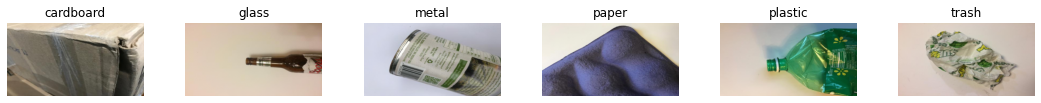

In [6]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [7]:
X = np.array(data['data'])
y = np.array(data['label'])

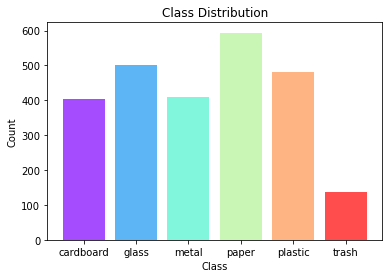

In [8]:
''' This was used to understand the data distribution better '''
def plot_histogram(y, title='Class Distribution', ylabel_text='count'):
    # Calculate counts per class and sort to ensure order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
    counts = counts[sorted_index]
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique)))
    
    # Plot histogram
    plt.bar(unique, counts, align='center', alpha=.7, color=colors)
    plt.xlabel('Class')
    plt.ylabel(ylabel_text)
    plt.title(title)
    plt.show()

y_data = y  
plot_histogram(y_data, title='Class Distribution', ylabel_text='Count')

In [9]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

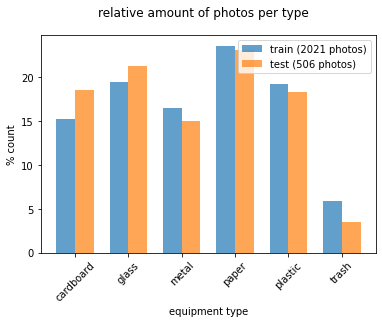

In [10]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)

plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
import skimage
from skimage.feature import hog
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer

# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(2021, 30240)


In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=10, random_state=0)
rf_clf.fit(X_train_prepared, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [31]:
# test the trained RF classifier
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [32]:
y_pred = rf_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[False False  True False  True  True  True False  True False False False
  True False False  True  True False False  True False False  True  True
  True]

Percentage correct:  53.16205533596838
